# Frequency-Domain Master Curve Validation

Validate RheoJAX oscillatory fits using the PyVisco master curve dataset.

In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports
Use the PyVisco master-curve dataset to validate RheoJAX oscillatory fits and compare generalized vs fractional models.

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rheojax.models import FractionalMaxwellModel
from rheojax.models import GeneralizedMaxwell

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)
import arviz as az


## Load master-curve data

Files live in `examples/data/mastercurves/freq_master/` and include storage/loss moduli (MPa) plus tabulated shift factors.

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'mastercurves' / 'freq_master'
master_df = pd.read_csv(DATA_DIR / 'freq_user_master.csv')
shift_df = pd.read_csv(DATA_DIR / 'freq_user_master__shift_factors.csv')

# Drop units row and coerce numeric
master_clean = master_df.iloc[1:].astype(float)

# Frequency in Hz → angular freq (rad/s)
freq_hz = master_clean['f'].to_numpy()
omega = 2 * np.pi * freq_hz
G_prime = master_clean['E_stor'].to_numpy()
G_double = master_clean['E_loss'].to_numpy()
G_star = G_prime + 1j * G_double

data = RheoData(
    x=omega,
    y=G_star,
    x_units='rad/s',
    y_units='MPa',
    domain='oscillation',
    metadata={'source': 'pyvisco_master', 'test_mode': 'oscillation'}
)
print(data)

# Display shift factors for reference
shift_df.head()


RheoData(x=array([6.2832e-12, 7.5541e-12, 1.2537e-11, 1.6275e-11, 2.7009e-11,
       3.5063e-11, 5.2261e-11, 5.8190e-11, 7.5541e-11, 1.1259e-10,
       1.2537e-10, 1.6275e-10, 2.4258e-10, 2.7009e-10, 3.5063e-10,
       4.1513e-10, 5.2261e-10, 5.8190e-10, 7.5541e-10, 8.9436e-10,
       1.1259e-09, 1.2537e-09, 1.6275e-09, 1.9268e-09, 2.1786e-09,
       2.4258e-09, 3.5063e-09, 4.1513e-09, 4.6937e-09, 5.2261e-09,
       7.5541e-09, 8.9436e-09, 1.0112e-08, 1.1259e-08, 1.1434e-08,
       1.9268e-08, 2.1786e-08, 2.4258e-08, 2.4633e-08, 4.1513e-08,
       4.6937e-08, 5.2261e-08, 5.3070e-08, 6.0004e-08, 8.9436e-08,
       1.0112e-07, 1.1434e-07, 1.2927e-07, 1.9268e-07, 2.1786e-07,
       2.4633e-07, 2.7427e-07, 2.7851e-07, 4.1513e-07, 4.6937e-07,
       5.3070e-07, 5.9090e-07, 6.0004e-07, 1.0112e-06, 1.1434e-06,
       1.2731e-06, 1.2927e-06, 1.4394e-06, 2.1786e-06, 2.4633e-06,
       2.7427e-06, 2.7851e-06, 3.1011e-06, 5.3070e-06, 5.9090e-06,
       6.0004e-06, 6.6811e-06, 8.6732e-06, 1.1434e-

,T,log_aT
0,C,-
1,100,-11.7
2,92,-10.92
3,85,-10.08
4,77,-9.18


## Visualize raw master curve

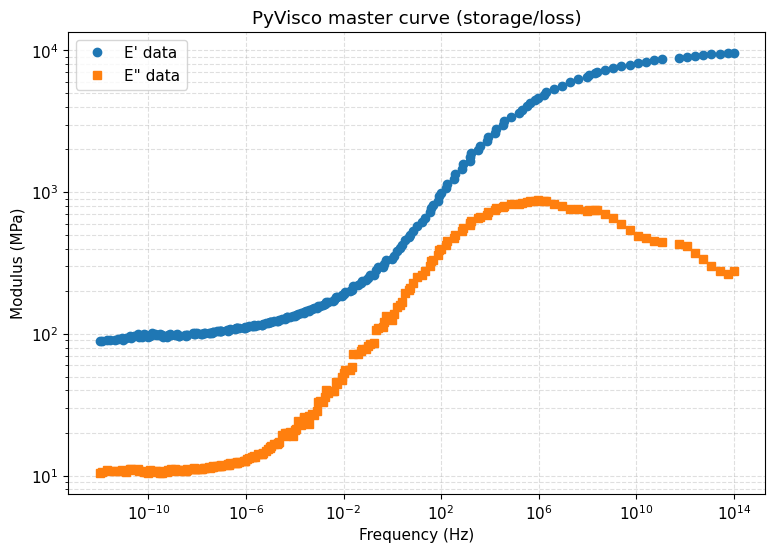

In [4]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(freq_hz, G_prime, 'o', label="E' data")
ax.loglog(freq_hz, G_double, 's', label='E" data')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Modulus (MPa)')
ax.set_title('PyVisco master curve (storage/loss)')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend();


## Fit RheoJAX models

We compare a 6-mode generalized Maxwell model (Prony-style) against the fractional Maxwell model. Both use log-space residuals to respect the wide frequency range.

In [5]:
# Generalized Maxwell accepts complex modulus directly
gm = GeneralizedMaxwell(n_modes=6, modulus_type='tensile')
gm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True, use_multi_start=True)
gm_pred_components = gm.predict(omega)
gm_pred = gm_pred_components[:, 0] + 1j * gm_pred_components[:, 1]
gm_r2 = r2_complex(G_star, gm_pred)

# Fractional Maxwell (fixed-parameter variant) with graceful fallback
fm_pred = np.full_like(G_star, np.nan)
fm_r2 = np.nan
try:
    fm = FractionalMaxwellModel()
    fm.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
    fm_pred = fm.predict(omega, test_mode='oscillation')
    fm_r2 = r2_complex(G_star, fm_pred)
except Exception as exc:
    print(f"Fractional Maxwell fit failed: {exc}")

print(f"Generalized Maxwell R^2: {gm_r2:.4f}")
print(f"Fractional Maxwell R^2:   {fm_r2 if np.isfinite(fm_r2) else float('nan'):.4f}")


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.691093s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=11 | final_cost=8.2029e+07 | elapsed=1.691s | final_gradient_norm=7.6496e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.346389s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=11 | final_cost=8.2029e+07 | elapsed=0.346s | final_gradient_norm=7.6496e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.450297s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=11 | final_cost=5.1732e+07 | elapsed=1.450s | final_gradient_norm=3.2108e+04


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.530424s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=18 | final_cost=5.1912e+07 | elapsed=1.530s | final_gradient_norm=7.2436e+12


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.326032s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=20 | final_cost=5.2594e+07 | elapsed=1.326s | final_gradient_norm=2.6742e+13


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.105804s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=22 | final_cost=5.5843e+07 | elapsed=1.106s | final_gradient_norm=2.3805e+13


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.117362s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=8.7084e+07 | elapsed=1.117s | final_gradient_norm=711.1144


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.740152s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=4.7268e+20 | elapsed=0.740s | final_gradient_norm=1.5690e+30


ERROR:rheojax.utils.optimization:Optimization failed: residual norm extremely large


ERROR:rheojax.models.fractional.fractional_maxwell_model:NLSQ optimization raised exception
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/models/fractional/fractional_maxwell_model.py", line 403, in _fit
    result = nlsq_optimize(
        objective,
    ...<3 lines>...
        max_iter=kwargs.get("max_iter", 1000),
    )
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 1122, in nlsq_optimize
    raise RuntimeError(
    ...<2 lines>...
    )
RuntimeError: Optimization failed: residual norm remains extremely large. Try providing better initial values, looser bounds, or scaling the data.


ERROR:rheojax.models.fractional.fractional_maxwell_model:model_fit failed: Optimization failed: residual norm remains extremely large. Try providing better initial values, looser bounds, or scaling the data.


ERROR:rheojax.core.base:Fit failed with RuntimeError
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 318, in fit
    self._fit(X, y, method=method, **kwargs)
    ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/fractional/fractional_maxwell_model.py", line 403, in _fit
    result = nlsq_optimize(
        objective,
    ...<3 lines>...
        max_iter=kwargs.get("max_iter", 1000),
    )
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 1122, in nlsq_optimize
    raise RuntimeError(
    ...<2 lines>...
    )
RuntimeError: Optimization failed: residual norm remains extremely large. Try providing better initial values, looser bounds, or scaling the data.


Fractional Maxwell fit failed: Optimization failed: residual norm remains extremely large. Try providing better initial values, looser bounds, or scaling the data.
Generalized Maxwell R^2: 0.9190
Fractional Maxwell R^2:   nan


## Overlay fits vs data

/var/folders/rq/lgpr8fvj349cr_wvkzv99md80000gp/T/ipykernel_81531/3845240182.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best')


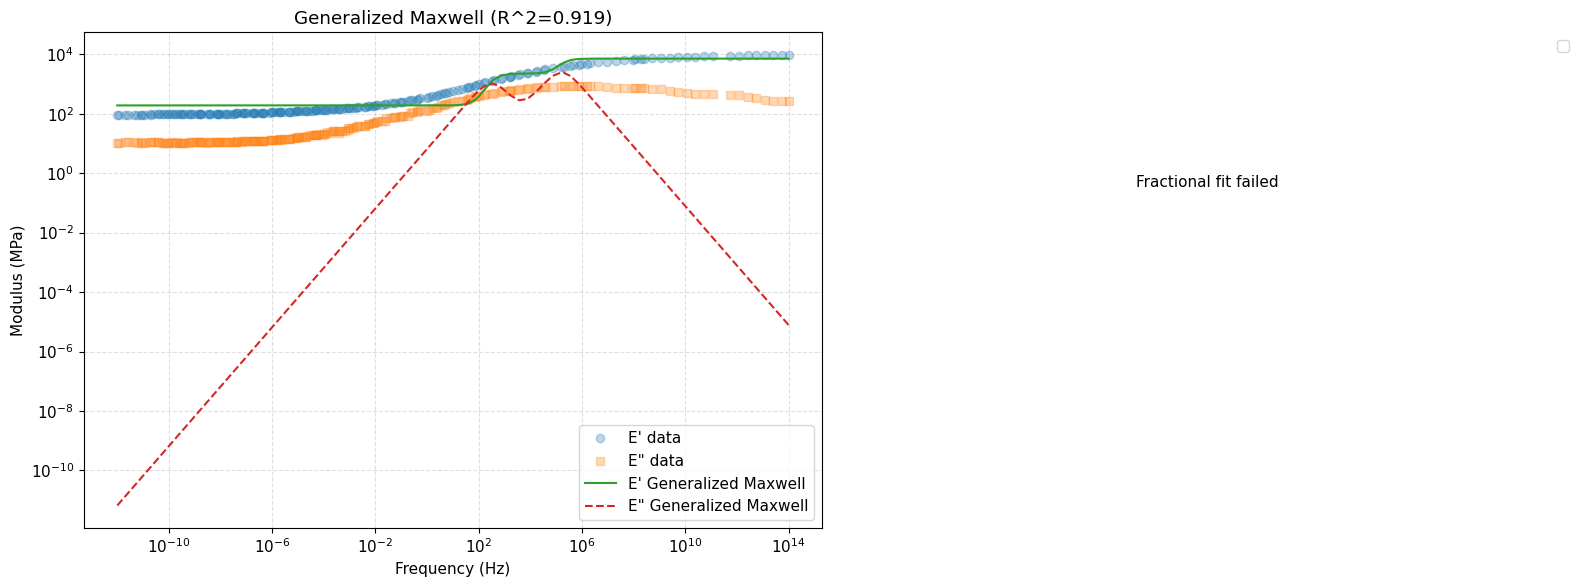

In [6]:
def plot_fit(ax, freq, data_complex, pred_complex, label):
    ax.loglog(freq, np.real(data_complex), 'o', alpha=0.3, label="E' data")
    ax.loglog(freq, np.imag(data_complex), 's', alpha=0.3, label='E" data')
    ax.loglog(freq, np.real(pred_complex), '-', label=f"E' {label}")
    ax.loglog(freq, np.imag(pred_complex), '--', label=f'E" {label}')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Modulus (MPa)')
    ax.grid(True, which='both', ls='--', alpha=0.4)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
plot_fit(axes[0], freq_hz, G_star, gm_pred, 'Generalized Maxwell')
axes[0].set_title(f'Generalized Maxwell (R^2={gm_r2:.3f})')

if np.isfinite(fm_r2):
    plot_fit(axes[1], freq_hz, G_star, fm_pred, 'Fractional Maxwell')
    axes[1].set_title(f'Fractional Maxwell (R^2={fm_r2:.3f})')
else:
    axes[1].axis('off')
    axes[1].text(0.5, 0.5, 'Fractional fit failed', ha='center', va='center')

for ax in axes:
    ax.legend(loc='best')
plt.tight_layout()
display(fig)
plt.close(fig)

## Residual diagnostics

In [7]:
def residual_mpe(y_true, y_pred):
    res = y_true - y_pred
    mpe = np.mean(np.abs(res) / np.maximum(np.abs(y_true), 1e-12)) * 100
    return float(mpe)

gm_mpe = residual_mpe(G_star, gm_pred)
fm_mpe = residual_mpe(G_star, fm_pred) if np.isfinite(fm_r2) else np.nan
print({'gm_mpe_%': gm_mpe, 'fm_mpe_%': fm_mpe})

{'gm_mpe_%': 57.71232110204153, 'fm_mpe_%': nan}


## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

In [8]:
# Helper functions for workflow
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        """Compute R² for complex-valued data."""
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        """Convert 2-column real array to complex if needed."""
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr

NUTS_CONFIG = dict(num_chains=1, num_warmup=200, num_samples=500)  # Fast demo mode


In [9]:
def _detect_datasets():
    """Auto-detect datasets from global variables."""
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': G_star, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': Gp + 1j * Gpp, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        test_mode = master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation'
        datasets.append({
            'X': master.x, 'y': master.y, 'test_mode': test_mode,
            'x_label': 'Shifted frequency', 'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({'X': t, 'y': G, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'E_t' in globals():
        datasets.append({'X': t, 'y': E_t, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'sigma' in globals():
        datasets.append({'X': t, 'y': sigma, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Stress (Pa)'})
    if 't' in globals() and 'J' in globals():
        datasets.append({'X': t, 'y': J, 'test_mode': 'creep', 'x_label': 'Time (s)', 'y_label': 'Creep compliance'})
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals, 'y': y_vals, 'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})', 'y_label': 'Stress (Pa)', 'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined.')
    return datasets

def _collect_candidate_models():
    """Collect candidate models from global variables."""
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running.')
    return models

datasets = _detect_datasets()
model_entries = _collect_candidate_models()
print(f"Found {len(datasets)} dataset(s) and {len(model_entries)} model(s)")


Found 1 dataset(s) and 2 model(s)


In [10]:
# NLSQ fitting loop - fit all models to all datasets
all_fits = {}  # {dataset_idx: [fit_records]}

for ds_idx, ds in enumerate(datasets):
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            try:
                fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
            except Exception as exc:
                print(f"Skipping {name} due to fit error: {exc}")
                continue
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue

        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue

        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue

        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    all_fits[ds_idx] = fits
    if fits:
        print(f"Dataset {ds_idx} ranking: {[(r['name'], round(r['r2'], 3)) for r in fits]}")
    else:
        print(f"Dataset {ds_idx}: No successful fits")


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.389321s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=45 | final_cost=5.5843e+07 | elapsed=0.389s | final_gradient_norm=1.3114e+04


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.338648s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=45 | final_cost=5.5843e+07 | elapsed=0.339s | final_gradient_norm=1.3114e+04


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.247328s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=8.7084e+07 | elapsed=0.247s | final_gradient_norm=710.7176


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
TypeError: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Skipping gm due to predict error: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.285317s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=4.7268e+20 | elapsed=0.285s | final_gradient_norm=1.5690e+30


ERROR:rheojax.utils.optimization:Optimization failed: residual norm extremely large


ERROR:rheojax.models.fractional.fractional_maxwell_model:NLSQ optimization raised exception
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/models/fractional/fractional_maxwell_model.py", line 403, in _fit
    result = nlsq_optimize(
        objective,
    ...<3 lines>...
        max_iter=kwargs.get("max_iter", 1000),
    )
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 1122, in nlsq_optimize
    raise RuntimeError(
    ...<2 lines>...
    )
RuntimeError: Optimization failed: residual norm remains extremely large. Try providing better initial values, looser bounds, or scaling the data.


ERROR:rheojax.models.fractional.fractional_maxwell_model:model_fit failed: Optimization failed: residual norm remains extremely large. Try providing better initial values, looser bounds, or scaling the data.


ERROR:rheojax.core.base:Fit failed with RuntimeError
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 318, in fit
    self._fit(X, y, method=method, **kwargs)
    ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/fractional/fractional_maxwell_model.py", line 403, in _fit
    result = nlsq_optimize(
        objective,
    ...<3 lines>...
        max_iter=kwargs.get("max_iter", 1000),
    )
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 1122, in nlsq_optimize
    raise RuntimeError(
    ...<2 lines>...
    )
RuntimeError: Optimization failed: residual norm remains extremely large. Try providing better initial values, looser bounds, or scaling the data.


Skipping fm due to fit error: Optimization failed: residual norm remains extremely large. Try providing better initial values, looser bounds, or scaling the data.
Dataset 0: No successful fits


In [11]:
# Bayesian inference on best model per dataset
def _plot_data_and_fits(ds, fits):
    """Plot data with model fits overlay."""
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot, y_true = ds['X'], ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        ax.loglog(X_plot, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(X_plot, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)

bayes_results = {}  # {dataset_idx: inference_data}

for ds_idx, ds in enumerate(datasets):
    fits = all_fits.get(ds_idx, [])
    if not fits:
        continue

    best = fits[0]
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'], ds['y'], **NUTS_CONFIG, test_mode=ds['test_mode'],
        )
        bayes_results[ds_idx] = bayes_result.to_inference_data()
        print(f"Dataset {ds_idx}: Bayesian inference complete for {best['name']}")
    except Exception as exc:
        print(f"Dataset {ds_idx}: Bayesian step failed for {best['name']}: {exc}")


In [12]:
# ArviZ diagnostics for Bayesian results
def _plot_diagnostics(idata):
    """Generate ArviZ diagnostic plots."""
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
            plt.tight_layout()
            display(obj)
            plt.close('all')
        except Exception as exc:
            print(f"Skipping {name} plot: {exc}")

for ds_idx, idata in bayes_results.items():
    print(f"\n--- Diagnostics for dataset {ds_idx} ---")
    _plot_diagnostics(idata)
